# Exercise XI: Embeddings

## Part 1: Dimensionality Reduction & The Neural Manifold

### **Introduction**
In neuroscience, we often record from hundreds or thousands of neurons simultaneously. However, the "true" state of the brain often lives on a much simpler, lower-dimensional manifold. Embeddings allow us to learn a dense representation of this high-dimensional data.
We can use techniques like PCA, t-SNE, or UMAP to project high-dimensional data (like 784-dimensional MNIST images) into a 2D or 3D space to reveal hidden clusters and relationships.

### **Task: Visualizing the Latent Space**
In this exercise, we will:

* Generate high-dimensional synthetic "neural activity" representing different behavioral states.

* Use PCA and UMAP to create embeddings.

* Visualize how these embeddings reveal the underlying structure of the data.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.datasets import make_blobs

plt.style.use('bmh')
plt.rcParams.update({'font.size': 12})

# 1. Simulate High-Dimensional Neural Data
# Imagine P neurons (dimensions) recording N timepoints (samples)
# We simulate 4 distinct "behavioral states" (e.g., Reach, Rest, Walk, Eat)
n_samples = 1000
n_neurons = 100
n_states = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_neurons, centers=n_states, 
                  cluster_std=4.0, random_state=42)

print(f"Original Data Shape: {X.shape} (Timepoints, Neurons)")

Original Data Shape: (1000, 100) (Timepoints, Neurons)


/home/groot/Projects/courses/ml_for_neuro/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


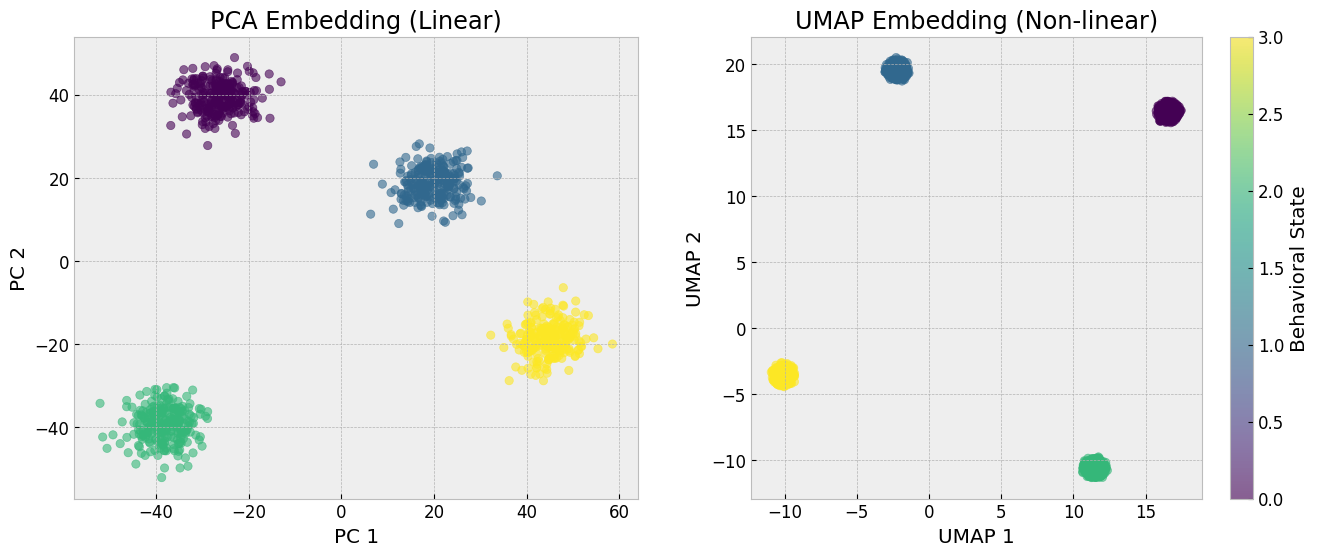

In [38]:
# 2. Apply Dimensionality Reduction to create Embeddings
# We'll compare PCA (linear) vs UMAP (non-linear)

# PCA Embedding
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# UMAP Embedding
umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X)

# 3. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot PCA
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
ax1.set_title("PCA Embedding (Linear)")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")

# Plot UMAP
scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.6)
ax2.set_title("UMAP Embedding (Non-linear)")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")

plt.colorbar(scatter2, ax=ax2, label='Behavioral State')
plt.show()

## **Part 2: Semantic Embeddings & Representational Similarity Analysis (RSA)**

### **Introduction**
In the previous section, we saw how embeddings can capture the "manifold" of neural population activity. In this section, we move to Semantic Embeddings, which represent the "meaning" of stimuli (such as words, images, or audio) as dense vectors.

We've previously discussed [**DistilBERT**]((https://huggingface.co/docs/transformers/en/model_doc/distilbert)), a model that transforms **text into a 768-dimensional embedding space**. In neuroscience, we use these embeddings to perform [Representational Similarity Analysis (RSA)](https://dartbrains.org/content/RSA.html)$^1$. RSA allows us to compare how a machine learning model "sees" the world versus how the brain represents the same stimuli.

![RSA](https://dartbrains.org/_images/similarity.jpg)


### **Task: Building a Semantic Similarity Matrix**
In this exercise, we will:

* Use a pre-trained transformer to generate embeddings for a set of stimulus words.

* Calculate the Cosine Similarity between these embeddings.

* Visualize the Representational Similarity Matrix (RSM) to see how the model clusters concepts.

In [39]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load a pre-trained model (equivalent to DistilBERT logic in slides)
# This model maps sentences/words to a 384-dimensional dense vector space
model = SentenceTransformer('all-MiniLM-L6-v2') 

# 2. Define our stimuli (Neuroscience experiment categories)
stimuli = [
    "cat", "dog", "lion",         # Animals
    "apple", "banana", "orange",  # Fruits
    "car", "truck", "train"       # Vehicles
]

# 3. Generate the embeddings
# Each word becomes a vector (Model Input -> Model Output)
embeddings = model.encode(stimuli)

print(f"Number of stimuli: {len(stimuli)}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Number of stimuli: 9
Embedding dimension: 384


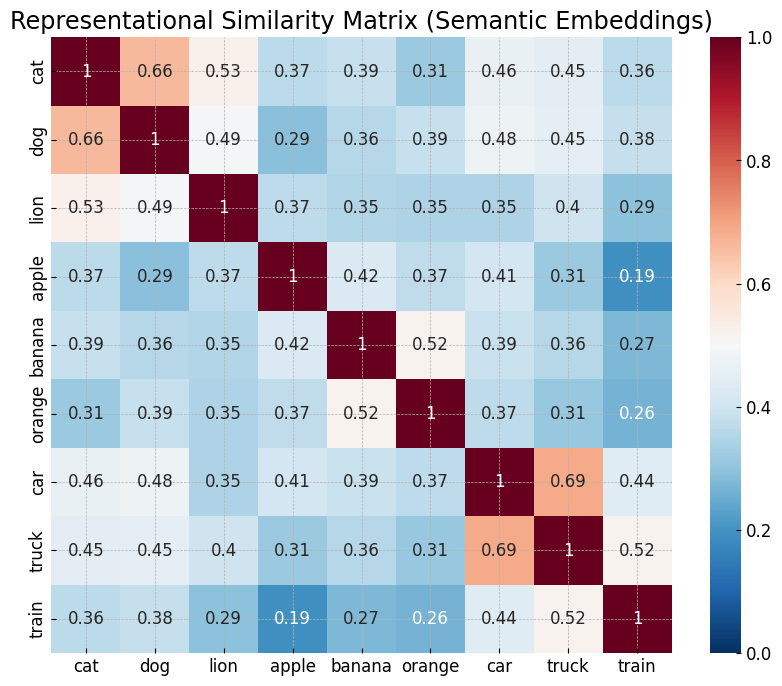

In [40]:
# 4. Compute the Cosine Similarity Matrix
# This tells us how "similar" each word vector is to every other vector
rsm = cosine_similarity(embeddings)

# 5. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rsm, annot=True, xticklabels=stimuli, yticklabels=stimuli, 
            cmap='RdBu_r', vmin=0, vmax=1)

plt.title("Representational Similarity Matrix (Semantic Embeddings)")
plt.show()

## **Part 2.5 (or 3): Downstream Tasks - Decoding from Embeddings**

### **Introduction**
Once we have mapped our data into a dense embedding space, we can use these vectors as inputs for supervised machine learning models (e.g, those we've worked with throughout the course). For example, in neuroscience, we might use embeddings of brain activity to predict a subject's behavior or use semantic embeddings to "decode" what word a person is thinking about.

For example, [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) can be used to generate embeddings that are then fed into a Logistic Regression model for tasks like sentiment analysis.


### **Task: Sentiment Classification from Text Embeddings**
In this exercise, we will:
* Embed a small dataset of sentences.
* Train a simple Logistic Regression classifier on these embeddings.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])

# sample 3000 rows for demo purposes
df = df.sample(n=3000, random_state=42).reset_index(drop=True)

# 1. Prepare a small labeled dataset for sentiment analysis
sentences = df['sentence'].tolist()
y = df['label'].tolist()  # 0 = negative, 1 = positive

# demonstrate "positive" and "negative" examples
rand_pos = df[df['label'] == 1]['sentence'].sample(3).values
rand_neg = df[df['label'] == 0]['sentence'].sample(3).values

print("Positive Examples:")
for sent in rand_pos:
    print(f" - {sent}")
print("\nNegative Examples:")
for sent in rand_neg:
    print(f" - {sent}")


Positive Examples:
 - to cut a swathe through mainstream hollywood 
 - with this one too 
 - cinematography to the outstanding soundtrack and unconventional narrative 

Negative Examples:
 - the human race splitting in two 
 - your favorite pet get buried alive 
 - a sketchy work-in-progress 


In [42]:

# 2. Generate Embeddings (768 dimensions per sentence)
print("Generating embeddings for 3000 SST-2 samples...")
transformer = SentenceTransformer('all-MiniLM-L6-v2') 
X_embeddings = transformer.encode(sentences)

print(f"Feature Matrix Shape: {X_embeddings.shape} (Samples, Embedding Dim)")

Generating embeddings for 3000 SST-2 samples...
Feature Matrix Shape: (3000, 384) (Samples, Embedding Dim)


Text(0.5, 1.0, 'ROC Curve for Sentiment Decoding')

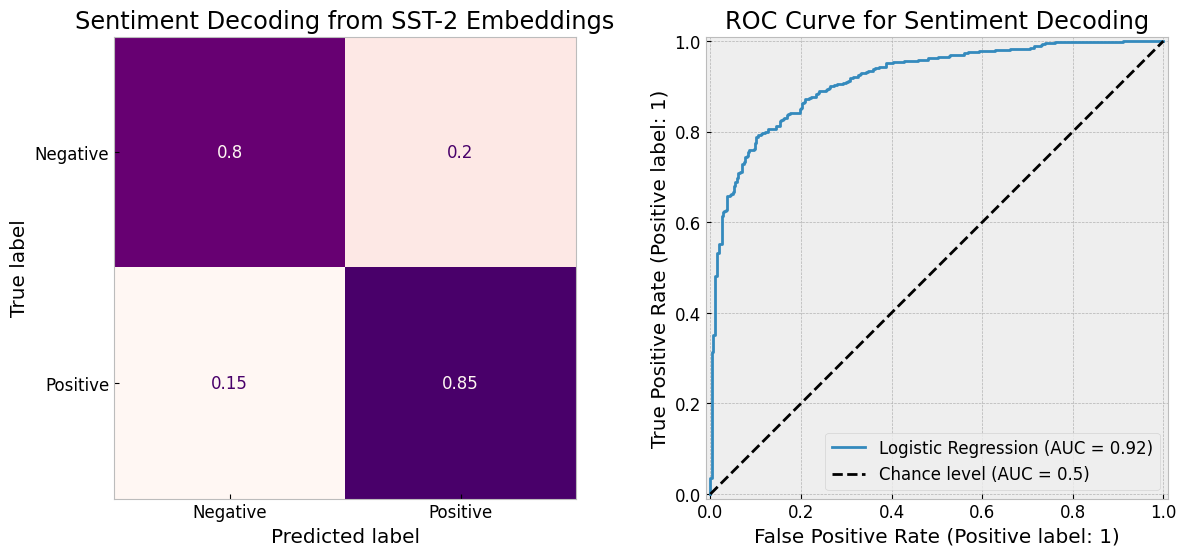

In [46]:
# 3. Split into Training and Testing sets (75% / 25%)
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.25, stratify=y, random_state=42
)

# 4. Train a Logistic Regression Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 5. Evaluate the results
y_pred = clf.predict(X_test)

# 6. Visualize the Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, 
                                      display_labels=['Negative', 'Positive'], 
                                      cmap='RdPu',
                                      normalize='true',
                                      ax=axes[0],
                                      colorbar=False
                                      )
axes[0].set_title("Sentiment Decoding from SST-2 Embeddings")
axes[0].grid(False)

from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1], name='Logistic Regression', plot_chance_level=True)
axes[1].set_title("ROC Curve for Sentiment Decoding")



### **The "Encoder" Matters**
Different data types require different Encoders:

* **Text**: [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) or [GloVe](https://nlp.stanford.edu/projects/glove/).
* **Audio**: [VGGish](https://v-iashin.github.io/video_features/models/vggish/) (converting spectrograms to vectors).
* **Images**: [CLIP](https://openai.com/index/clip/) (aligning images and text in the same space).

**Rule of Thumb**: When analyzing brain data, the "biological plausibility" of your results often depends on the encoder you choose. For example, using a model trained on 400 million image-caption pairs (like CLIP) might be a better "brain-like" representation of visual objects than a model trained only on pixel labels.

[1] Kriegeskorte, N., Mur, M., & Bandettini, P. A. (2008). Representational similarity analysis-connecting the branches of systems neuroscience. Frontiers in systems neuroscience, 2, 249.